In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_lfw_people
from kneed import KneeLocator

from utils import multiplicative_updates, hals_update
from utils import plot_nmf_components, plot_reconstructed_images, plot_matrix_histogram

In [2]:
n = 100 # n samples
m = 25 # m features
r = 20

np.random.seed(0)
X = np.abs(np.random.randn(n,m))

# Apply NMF
W, H = multiplicative_updates(
    X,
    n_components=r, 
    max_iter=1500, 
    random_state=42, 
    verbose=True
)

# Check reconstruction
X_reconstructed =  W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nFinal reconstruction error: {error:.4f}")

Initial error: 30.3606
Iteration 500/1500, Frobenius error: 10.1601
Iteration 1000/1500, Frobenius error: 10.0173
Iteration 1500/1500, Frobenius error: 9.9888

Final reconstruction error: 9.9888


# NMS for Facial Feature Extraction

In [2]:
# Load LFW dataset
faces = fetch_lfw_people(min_faces_per_person=70, resize=0.4)
images = faces.images  # shape (n_samples, height, width)

images_shape = images.shape[1:]
X = faces.data.T  # shape (n_features, n_samples)
    
print(f"Images shape: (height, width) = {images_shape}")
print(f"Dataset shape: (n,m) = {X.shape}")

Images shape: (height, width) = (50, 37)
Dataset shape: (n,m) = (1850, 1288)


## MU for different ranks

In [4]:
ranks = [5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training NMF for rank {r}...")
    W, H = multiplicative_updates(
        X,
        n_components=r, 
        max_iter=2000, 
        random_state=42,
        verbose=True
    )
    
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

Training NMF for rank 5...
Initial error: 395.1906
Iteration 500/2000, Frobenius error: 160.0136
Iteration 1000/2000, Frobenius error: 159.8786
Iteration 1500/2000, Frobenius error: 159.8105
Iteration 2000/2000, Frobenius error: 159.7593
Training NMF for rank 10...
Initial error: 340.1345
Iteration 500/2000, Frobenius error: 142.6784
Iteration 1000/2000, Frobenius error: 142.1067
Iteration 1500/2000, Frobenius error: 141.9200
Iteration 2000/2000, Frobenius error: 141.8210
Training NMF for rank 20...
Initial error: 306.0037
Iteration 500/2000, Frobenius error: 123.6428
Iteration 1000/2000, Frobenius error: 122.3069
Iteration 1500/2000, Frobenius error: 121.9324
Iteration 2000/2000, Frobenius error: 121.7492
Training NMF for rank 30...
Initial error: 293.3768
Iteration 500/2000, Frobenius error: 113.8954
Iteration 1000/2000, Frobenius error: 112.0326
Iteration 1500/2000, Frobenius error: 111.3409
Iteration 2000/2000, Frobenius error: 110.9661
Training NMF for rank 40...
Initial error: 28

### Reconstruction Error vs. Rank

Elbow at rank: 50


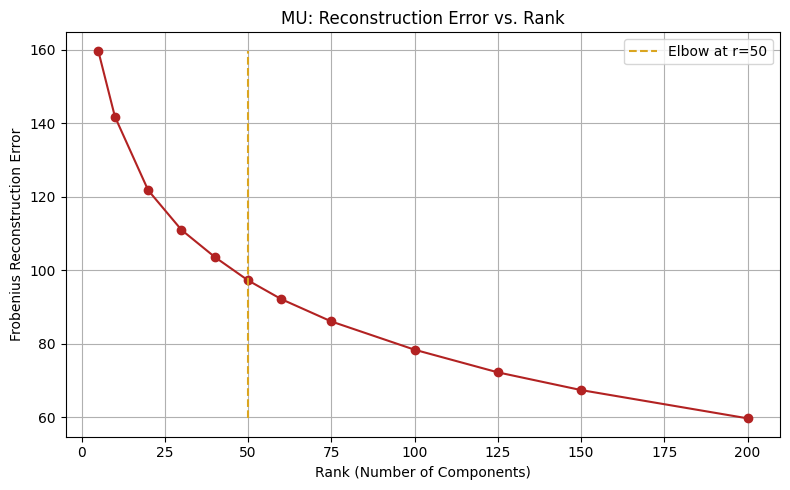

In [15]:
ranks_vals = []
plt_errors = []

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        ranks_vals.append(r)
        plt_errors.append(data['error'].item())

knee = KneeLocator(ranks_vals, plt_errors, curve='convex', direction='decreasing')
print("Elbow at rank:", knee.knee)

# Plot with elbow marked
plt.figure(figsize=(8, 5))
plt.plot(ranks_vals, plt_errors, marker='o',color='firebrick')
plt.vlines(knee.knee, min(plt_errors), max(plt_errors), linestyles='dashed', colors='goldenrod', label=f"Elbow at r={knee.knee}")
plt.title('MU: Reconstruction Error vs. Rank')
plt.xlabel('Rank (Number of Components)')
plt.ylabel('Frobenius Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


The terms "knee" and "elbow" from the KneeLocator package both refer to the point of maximum curvature in a curve — often used to find the optimal value of a parameter like the number of components in PCA or NMF, or clusters in K-Means.

The KneeLocator package is a Python utility to automatically detect the "knee" or "elbow" point in a curve — which is usually where increasing a parameter (like rank) gives diminishing returns in reducing error.

They're the same concept, just used for curves with different orientations. Elbow: When the curve is decreasing (like reconstruction error vs. rank). Knee: When the curve is increasing (like explained variance vs. components).

## Basis components and reconstruction


The reconstruction error for rank 20 is: 121.7492


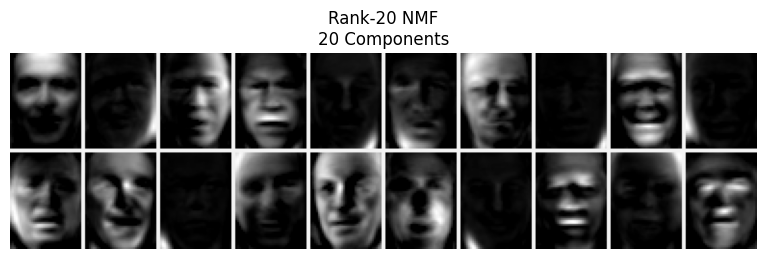

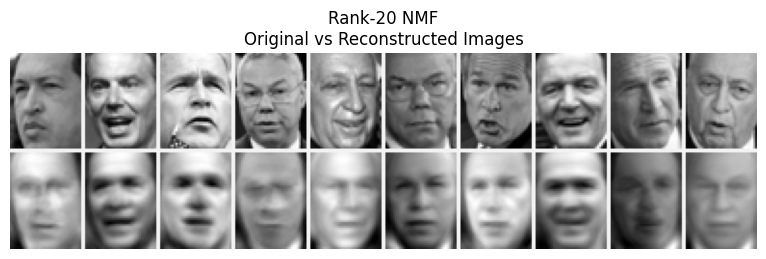

In [6]:
r = 20
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 20
plot_nmf_components(
    W, 
    image_shape=images_shape, 
    n_components=n_components,
    n_cols=10, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

### Rank-50


The reconstruction error for rank 50 is: 97.2173


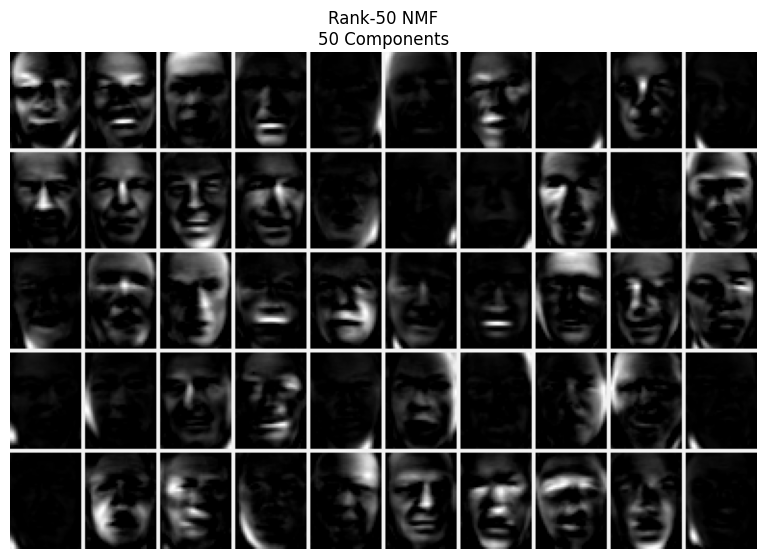

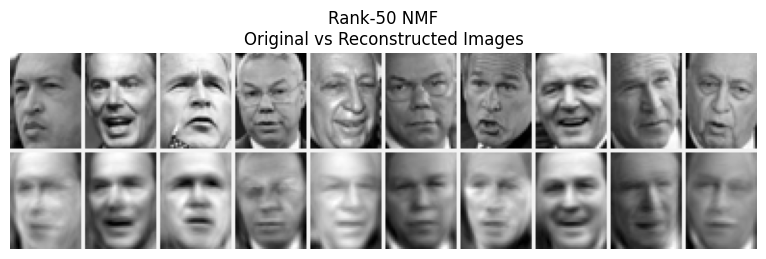

In [7]:
r = 50
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 50
plot_nmf_components(
    W,
    image_shape=images_shape, 
    n_components=n_components,
    n_cols=10, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

### Rank-250


The reconstruction error for rank 200 is: 59.6594


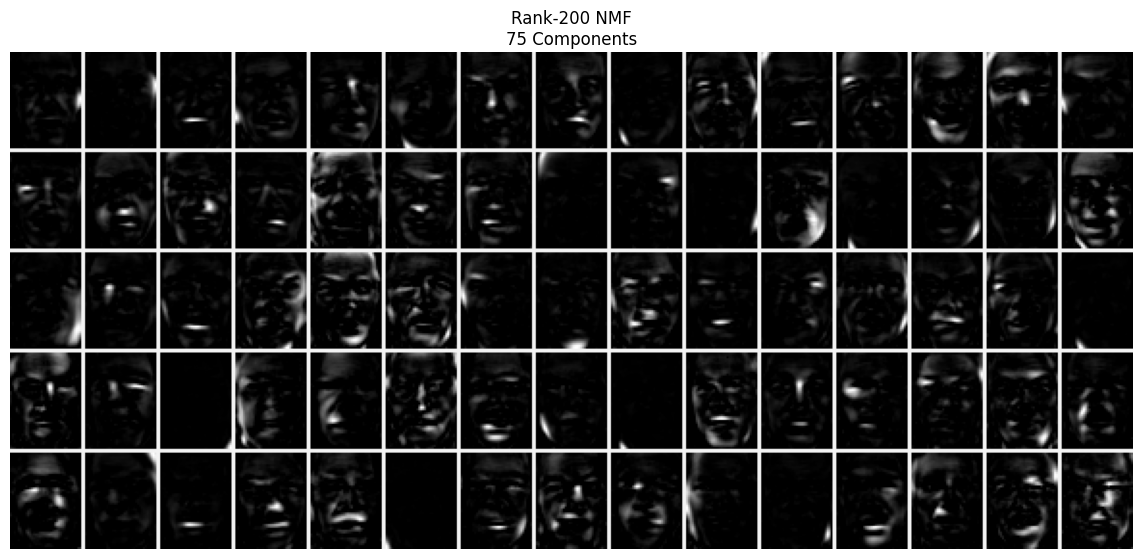

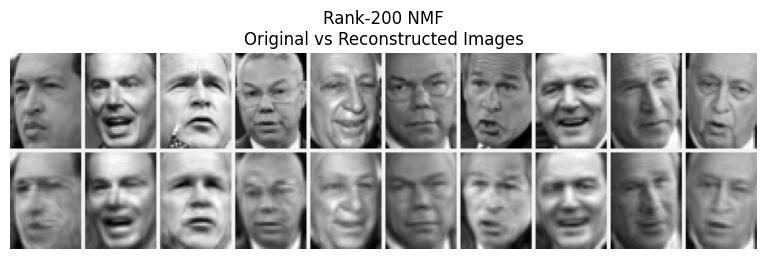

In [8]:
r = 200
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

# Check reconstruction
X_reconstructed = W @ H
error = np.linalg.norm(X - X_reconstructed, 'fro')
print(f"\nThe reconstruction error for rank {r} is: {error:.4f}")

n_components = 75
plot_nmf_components(
    W, 
    image_shape=images_shape, 
    n_components=n_components, 
    n_cols=15, 
    title=f"Rank-{r} NMF\n{n_components} Components"
)

plot_reconstructed_images(
    X, X_reconstructed,
    image_shape=images_shape,
    indices=list(range(0,10)),
    n_cols=10,
    title=f"Rank-{r} NMF\nOriginal vs Reconstructed Images"
)

## Sparcity

Fraction of near-zero entries in rank-50 NMF:
    - In W: 34.32%
    - In H: 14.39%


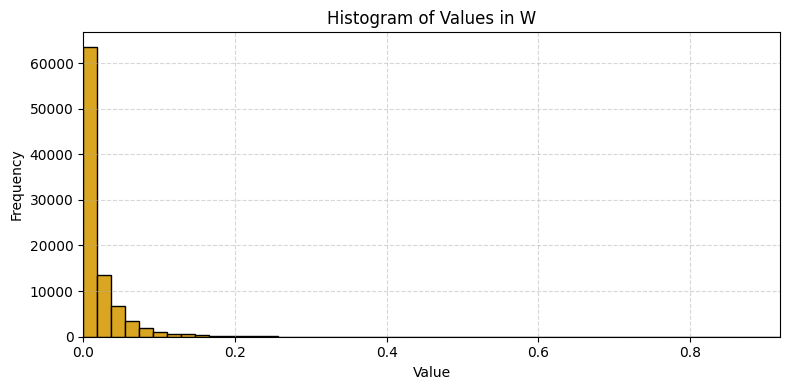

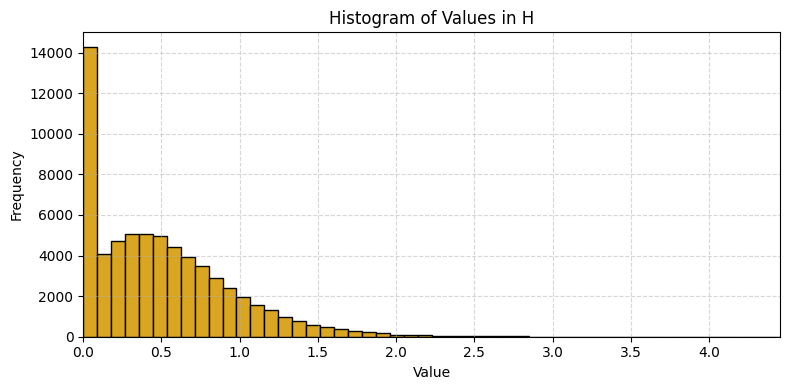

In [9]:
r = 50
data = np.load(f"nmf_models/mu_nmf_rank_{r}.npz")
W = data['W']
H = data['H']

print(f"Fraction of near-zero entries in rank-{r} NMF:")
print(f"    - In W: {np.mean(W < 1e-3):.2%}")
print(f"    - In H: {np.mean(H < 1e-3):.2%}")

plot_matrix_histogram(W,"W")
plot_matrix_histogram(H,"H")

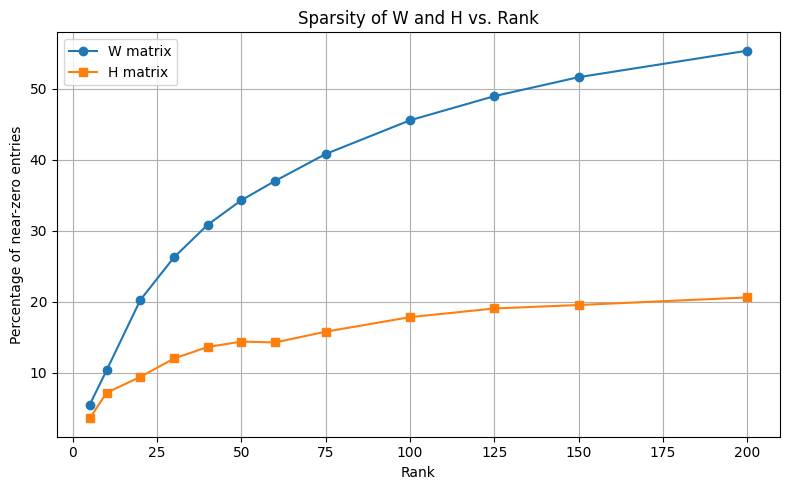

In [10]:
ranks_vals = []
sparsity_vals_W = []
sparsity_vals_H = []

for r in ranks:
    filename = f"nmf_models/mu_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        W = data['W']
        H = data['H']
        
        ranks_vals.append(r)
        # W < 1e-3 creates a boolean array
        sparsity_vals_W.append(np.mean(W < 1e-3)*100)
        sparsity_vals_H.append(np.mean(H < 1e-3)*100)

# Plot
plt.figure(figsize=(8, 5))
plt.plot(ranks_vals, sparsity_vals_W, marker='o', label='W matrix')
plt.plot(ranks_vals, sparsity_vals_H, marker='s', label='H matrix')
plt.xlabel('Rank')
plt.ylabel('Percentage of near-zero entries')
plt.title('Sparsity of W and H vs. Rank')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## HALS fro different ranks

In [4]:
ranks = [5, 10, 20, 30, 40, 50, 60, 75, 100, 125, 150, 200]

os.makedirs("nmf_models", exist_ok=True)

for r in ranks:
    filename = f"nmf_models/hals_nmf_rank_{r}.npz"
    
    if os.path.exists(filename):
        print(f"File for rank {r} already exists. Skipping...")
        continue

    print(f"Training HALS for rank {r}...")
    W, H = hals_update(
        X,
        n_components=r, 
        max_iter=2000, 
        random_state=42,
        verbose=True
    )
    
    error = np.linalg.norm(X - W @ H, 'fro')

    np.savez_compressed(filename, W=W, H=H, error=error)

Training HALS for rank 5...
Initial error: 395.1906
Converged at iteration 64 with relative change 9.9332e-05
Training HALS for rank 10...
Initial error: 340.1345
Converged at iteration 111 with relative change 9.9475e-05
Training HALS for rank 20...
Initial error: 306.0037
Converged at iteration 177 with relative change 9.9524e-05
Training HALS for rank 30...
Initial error: 293.3768
Converged at iteration 148 with relative change 9.9243e-05
Training HALS for rank 40...
Initial error: 288.8275
Converged at iteration 187 with relative change 9.8941e-05
Training HALS for rank 50...
Initial error: 285.6509
Converged at iteration 209 with relative change 9.9772e-05
Training HALS for rank 60...
Initial error: 282.6817
Converged at iteration 227 with relative change 9.9929e-05
Training HALS for rank 75...
Initial error: 278.9048
Converged at iteration 228 with relative change 9.9936e-05
Training HALS for rank 100...
Initial error: 276.4139
Converged at iteration 299 with relative change 9.97

Elbow at rank: 60


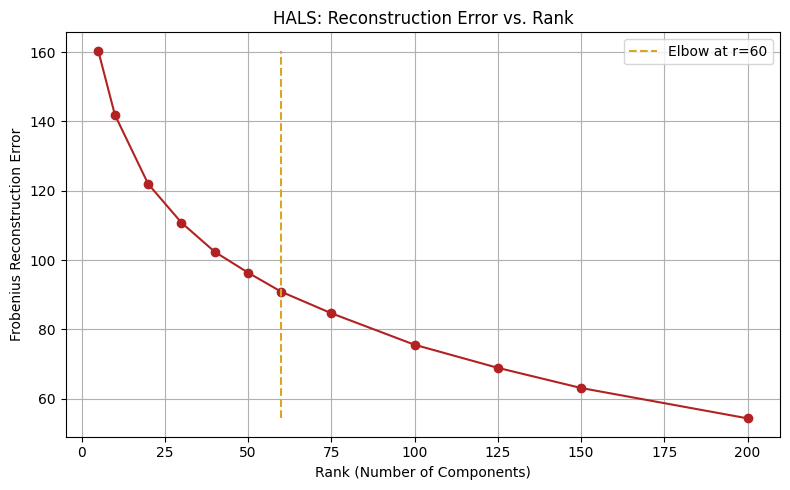

In [ ]:
ranks_vals = []
plt_hals_errors = []

for r in ranks:
    filename = f"nmf_models/hals_nmf_rank_{r}.npz"
    if os.path.exists(filename):
        data = np.load(filename)
        ranks_vals.append(r)
        plt_hals_errors.append(data['error'].item())

knee = KneeLocator(ranks_vals, plt_hals_errors, curve='convex', direction='decreasing')
print("Elbow at rank:", knee.knee)

# Plot with elbow marked
plt.figure(figsize=(8, 5))
plt.plot(ranks_vals, plt_hals_errors, marker='o',color='firebrick')
plt.vlines(knee.knee, min(plt_hals_errors), max(plt_hals_errors), linestyles='dashed', colors='goldenrod', label=f"Elbow at r={knee.knee}")
plt.title('HALS: Reconstruction Error vs. Rank')
plt.xlabel('Rank (Number of Components)')
plt.ylabel('Frobenius Reconstruction Error')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Compare MU with HALS

Define initial matrices `W_init` and `H_init`, apply both MU and HALS algorithms with the same initial conditions, and compare the results.

In [ ]:
def generate_W_H(m, n, r, random_state):
    rng = np.random.default_rng(random_state)
    W = rng.random((m, r))
    H = rng.random((r, n))
    return W, H

m, n = X.shape
r = 50
W_init, H_init = generate_W_H(m, n, r, random_state=42)
